In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../firmware')
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import array
import re

import pandas
import numpy

import plotly.express
import librosa
from matplotlib import pyplot as plt

from software.features.spectral import design_bandpass, plot_bandpass
from software.features.featureutils import resample, rms, vector_magnitude
from software.dataset.combine import read_labels, parse_video_filename, apply_labels
from software.dataset.combine import load_sensor_data as load_data


In [7]:
sensor_data_path = '../data/jonnor-brushing-1/har_record/'
labels_path  = '../data/jonnor-brushing-1/labels/project-7-at-2024-12-31-23-50-84589958.csv'

samplerate = 50
lower = 2.0
upper = 5.0

In [8]:
bandpass_sos = design_bandpass(lower=lower, upper=upper, sr=samplerate, order=2)
#plot_bandpass(bandpass_sos, lower=lower, upper=upper, sr=samplerate);

In [9]:
# Load sensor data
data = load_data(sensor_data_path)
data = data.drop_duplicates(subset=['time'])
print(data.columns)
print(data.head(5))

Failed to read all data for array. Expected (250, 3) = 750 elements, could only read 75 elements. (file seems not fully written?)
Failed to read all data for array. Expected (250, 3) = 750 elements, could only read 75 elements. (file seems not fully written?)
Failed to read all data for array. Expected (250, 3) = 750 elements, could only read 75 elements. (file seems not fully written?)
Failed to read all data for array. Expected (250, 3) = 750 elements, could only read 675 elements. (file seems not fully written?)
Failed to read all data for array. Expected (250, 3) = 750 elements, could only read 150 elements. (file seems not fully written?)
Failed to read all data for array. Expected (250, 3) = 750 elements, could only read 675 elements. (file seems not fully written?)
Index(['time', 'x', 'y', 'z', 'filename'], dtype='object')
                     time         x         y         z  \
0 2024-12-31 16:36:39.000 -0.188971  0.220710 -0.716819   
1 2024-12-31 16:36:39.020 -0.280770 -0.1

In [18]:
data

time         x         y         z  \
0   2024-12-31 16:36:39.000 -0.188971  0.220710 -0.716819   
1   2024-12-31 16:36:39.020 -0.280770 -0.177252 -0.561052   
2   2024-12-31 16:36:39.040 -0.970244  0.058596 -0.466323   
3   2024-12-31 16:36:39.060 -0.625507 -0.083499 -0.180181   
4   2024-12-31 16:36:39.080 -0.642109  0.212897 -0.246101   
..                      ...       ...       ...       ...   
245 2024-12-31 15:56:32.900 -0.043458  0.890164 -0.000488   
246 2024-12-31 15:56:32.920 -0.042482  0.906766 -0.002930   
247 2024-12-31 15:56:32.940 -0.050783  0.897488  0.001953   
248 2024-12-31 15:56:32.960 -0.058107  0.888699  0.013184   
249 2024-12-31 15:56:32.980 -0.057131  0.893094  0.009278   

                           filename  
0    2024-12-31T163639_brushing.npy  
1    2024-12-31T163639_brushing.npy  
2    2024-12-31T163639_brushing.npy  
3    2024-12-31T163639_brushing.npy  
4    2024-12-31T163639_brushing.npy  
..                              ...  
245  2024-12-31T155628_brushing.npy  
246  2024-12-31T155628_brushing.npy  
247  2024-12-31T155628_brushing.npy  
248  2024-12-31T155628_brushing.npy  
249  2024-12-31T155628_brushing.npy  

[53050 rows x 5 columns]

In [10]:
# Load labels
labels = read_labels(labels_path)
labels['gdrive_id'] = labels['filename'].str.replace('ucexportdownloadid', '')
labels = labels.drop(columns=['data_url', 'file', 'filename'])
labels

start         end  channel     class  annotation_id  lead_time  \
0     7.242452    9.739849        0      sync            139   1158.204   
1    25.972932   40.083226        0  brushing            139   1158.204   
2    44.578541   54.693000        0  brushing            139   1158.204   
3    60.811623   70.676342        0  brushing            139   1158.204   
4    77.169575  100.645110        0  brushing            139   1158.204   
5   113.631575  147.346438        0  brushing            139   1158.204   
6   159.084205  161.456733        0      sync            139   1158.204   
7     6.167842    8.086727        0      sync            140    216.716   
8    23.848991   47.560919        0  brushing            140    216.716   
9    52.906382   72.780541        0  brushing            140    216.716   
10   79.907826   98.822543        0  brushing            140    216.716   
11  122.671533  164.475799        0  brushing            140    216.716   
12  176.674421  177.907989        0      sync            140    216.716   
13   19.078740   21.350018        0      sync            141    301.568   
14   47.696849   73.892262        0  brushing            141    301.568   
15   83.583050   98.119233        0  brushing            141    301.568   
16  107.961440  144.301896        0  brushing            141    301.568   
17  158.383823  174.282773        0  brushing            141    301.568   
18  190.938816  193.058676        0      sync            141    301.568   
19    8.507726   10.708000        0      sync            142    454.470   
20  178.808932  181.155890        0      sync            142    454.470   
21   25.083123   43.418740        0  brushing            142    454.470   
22   48.112658   67.915123        0  brushing            142    454.470   
23   77.596329  106.786630        0  brushing            142    454.470   
24  117.494630  158.126356        0  brushing            142    454.470   

                     updated_at  \
0   2024-12-31T21:24:04.270312Z   
1   2024-12-31T21:24:04.270312Z   
2   2024-12-31T21:24:04.270312Z   
3   2024-12-31T21:24:04.270312Z   
4   2024-12-31T21:24:04.270312Z   
5   2024-12-31T21:24:04.270312Z   
6   2024-12-31T21:24:04.270312Z   
7   2024-12-31T23:50:16.662274Z   
8   2024-12-31T23:50:16.662274Z   
9   2024-12-31T23:50:16.662274Z   
10  2024-12-31T23:50:16.662274Z   
11  2024-12-31T23:50:16.662274Z   
12  2024-12-31T23:50:16.662274Z   
13  2024-12-31T21:39:40.412106Z   
14  2024-12-31T21:39:40.412106Z   
15  2024-12-31T21:39:40.412106Z   
16  2024-12-31T21:39:40.412106Z   
17  2024-12-31T21:39:40.412106Z   
18  2024-12-31T21:39:40.412106Z   
19  2024-12-31T21:47:17.028054Z   
20  2024-12-31T21:47:17.028054Z   
21  2024-12-31T21:47:17.028054Z   
22  2024-12-31T21:47:17.028054Z   
23  2024-12-31T21:47:17.028054Z   
24  2024-12-31T21:47:17.028054Z   

                                             activity  \
0   [{"start":7.24245205479452,"end":9.73984931506...   
1   [{"start":7.24245205479452,"end":9.73984931506...   
2   [{"start":7.24245205479452,"end":9.73984931506...   
3   [{"start":7.24245205479452,"end":9.73984931506...   
4   [{"start":7.24245205479452,"end":9.73984931506...   
5   [{"start":7.24245205479452,"end":9.73984931506...   
6   [{"start":7.24245205479452,"end":9.73984931506...   
7   [{"start":6.1678424657534245,"end":8.086726788...   
8   [{"start":6.1678424657534245,"end":8.086726788...   
9   [{"start":6.1678424657534245,"end":8.086726788...   
10  [{"start":6.1678424657534245,"end":8.086726788...   
11  [{"start":6.1678424657534245,"end":8.086726788...   
12  [{"start":6.1678424657534245,"end":8.086726788...   
13  [{"start":19.078739726027397,"end":21.35001826...   
14  [{"start":19.078739726027397,"end":21.35001826...   
15  [{"start":19.078739726027397,"end":21.35001826...   
16  [{"start":19.078739726027397,"end":21.35001826...   
17  [{"start":19.078739726027397,"end":21.35001826...   
18  [{"start":19.078739726027397,"end":21.35001826...   
19  [{"

In [12]:
videos_path = '../data/jonnor-brushing-1/videos.csv'
videos = pandas.read_csv(videos_path)
videos['file_time'] = videos.filename.apply(parse_video_filename)
gdrive_prefix = 'https://drive.google.com/uc?export=download&id='
videos['gdrive_id'] = videos['data_url'].str.replace(gdrive_prefix, '')
videos = videos.drop(columns=['data_url'])
videos

filename  label_alignment           file_time  \
0  VID_20241231_154514.mkv              2.0 2024-12-31 15:45:14   
1  VID_20241231_155624.mkv              0.7 2024-12-31 15:56:24   
2  VID_20241231_163515.mkv             15.5 2024-12-31 16:35:15   
3  VID_20241231_164646.mkv              4.4 2024-12-31 16:46:46   

                           gdrive_id  
0  1ZXXXHchyxcGobjLIijU4ONue1Md7UXY_  
1  1U7Bvx_OZpnpy88tx42hbUpaT5NBeCAgM  
2  1j6srphrD9ivL1r5UbcNsJqLz6WaAufKk  
3  1KR02iRh9_X7n-zDS2v6AkDSjxmaNporh

In [13]:
mm = pandas.merge(labels, videos, left_on='gdrive_id', right_on='gdrive_id')
mm = mm.drop(columns=['updated_at', 'created_at', 'lead_time', 'annotator', 'annotation_id', 'activity', 'channel', 'id'])
align_label = pandas.to_timedelta(mm['label_alignment'], unit='s')
mm['start_time'] = mm['file_time'] + align_label + pandas.to_timedelta(mm['start'], unit='s')
mm['end_time'] = mm['file_time'] + align_label + pandas.to_timedelta(mm['end'], unit='s')
mm['dummy_filename'] = 'only-one-sensor'
mm = mm.drop(columns=['file_time', 'start', 'end'])
mm = mm.drop(columns=['gdrive_id'])
mm

class   duration        gap                 filename  label_alignment  \
0       sync   2.497397  16.233082  VID_20241231_154514.mkv              2.0   
1   brushing  14.110295   4.495315  VID_20241231_154514.mkv              2.0   
2   brushing  10.114459   6.118623  VID_20241231_154514.mkv              2.0   
3   brushing   9.864719   6.493233  VID_20241231_154514.mkv              2.0   
4   brushing  23.475534  12.986466  VID_20241231_154514.mkv              2.0   
5   brushing  33.714863  11.737767  VID_20241231_154514.mkv              2.0   
6       sync   2.372527        NaN  VID_20241231_154514.mkv              2.0   
7       sync   1.918884  15.762264  VID_20241231_155624.mkv              0.7   
8   brushing  23.711928   5.345463  VID_20241231_155624.mkv              0.7   
9   brushing  19.874159   7.127285  VID_20241231_155624.mkv              0.7   
10  brushing  18.914717  23.848991  VID_20241231_155624.mkv              0.7   
11  brushing  41.804266  12.198622  VID_20241231_155624.mkv              0.7   
12      sync   1.233568        NaN  VID_20241231_155624.mkv              0.7   
13      sync   2.271279  26.346831  VID_20241231_163515.mkv             15.5   
14  brushing  26.195412   9.690788  VID_20241231_163515.mkv             15.5   
15  brushing  14.536183   9.842207  VID_20241231_163515.mkv             15.5   
16  brushing  36.340457  14.081927  VID_20241231_163515.mkv             15.5   
17  brushing  15.898950  16.656043  VID_20241231_163515.mkv             15.5   
18      sync   2.119860        NaN  VID_20241231_163515.mkv             15.5   
19      sync   2.200274  14.375123  VID_20241231_164646.mkv              4.4   
20      sync   2.346959        NaN  VID_20241231_164646.mkv              4.4   
21  brushing  18.335616   4.693918  VID_20241231_164646.mkv              4.4   
22  brushing  19.802466   9.681205  VID_20241231_164646.mkv              4.4   
23  brushing  29.190301  10.708000  VID_20241231_164646.mkv              4.4   
24  brushing  40.631726  20.682575  VID_20241231_164646.mkv              4.4   

                      start_time                      end_time  \
0  2024-12-31 15:45:23.242452055 2024-12-31 15:45:25.739849315   
1  2024-12-31 15:45:41.972931507 2024-12-31 15:45:56.083226027   
2  2024-12-31 15:46:00.578541096 2024-12-31 15:46:10.693000000   
3  2024-12-31 15:46:16.811623288 2024-12-31 15:46:26.676342466   
4  2024-12-31 15:46:33.169575342 2024-12-31 15:46:56.645109589   
5  2024-12-31 15:47:09.631575342 2024-12-31 15:47:43.346438356   
6  2024-12-31 15:47:55.084205479 2024-12-31 15:47:57.456732877   
7  2024-12-31 15:56:30.867842466 2024-12-31 15:56:32.786726788   
8  2024-12-31 15:56:48.548990868 2024-12-31 15:57:12.260918569   
9  2024-12-31 15:57:17.606382040 2024-12-31 15:57:37.480541096   
10 2024-12-31 15:57:44.607825723 2024-12-31 15:58:03.522542618   
11 2024-12-31 15:58:27.371533486 2024-12-31 15:59:09.175799087   
12 2024-12-31 15:59:21.374420852 2024-12-31 15:59:22.607989346   
13 2024-12-31 16:35:49.578739726 2024-12-31 16:35:51.850018265   
14 2024-12-31 16:36:18.196849315 2024-12-31 16:36:44.392261796   
15 2024-12-31 16:36:54.083050228 2024-12-31 16:37:08.619232877   
16 2024-12-31 16:37:18.461439878 2024-12-31 16:37:54.801896499   
17 2024-12-31 16:38:08.883823440 2024-12-31 16:38:24.782773212   
18 2024-12-31 16:38:41.438815830 2024-12-31 16:38:43.558675799   
19 2024-12-31 16:46:58.907726027 2024-12-31 16:47:01.108000000   
20 2024-12-31 16:49:49.208931507 2024-12-31 16:49:51.555890411   
21 2024-12-31 16:47:15.483123288 2024-12-31 16:47:33.818739726   
22 2024-12-31 16:47:38.512657534 2024-12-31 16:47:58.315123288   
23 2024-12-31 16:48:07.996328767 2024-12-31 16:48:37.186630137   
24 2024-12-31 16:48:47.894630137 2024-12-31 16:49:28.526356164   

     dummy_filename  
0   only-one-sensor  
1   only-one-sensor  
2   only-one-sensor  
3   only-one-sensor  
4   only-one-sensor  
5   only-one-sensor  
6   only-one-sensor  
7   only-one-sensor  
8   only-on

In [14]:
mm.groupby(['filename', 'class'])['duration'].sum()

filename                 class   
VID_20241231_154514.mkv  brushing     91.279870
                         sync          4.869925
VID_20241231_155624.mkv  brushing    104.305069
                         sync          3.152453
VID_20241231_163515.mkv  brushing     92.971002
                         sync          4.391139
VID_20241231_164646.mkv  brushing    107.960110
                         sync          4.547233
Name: duration, dtype: float64

In [15]:
def apply_sessions(data, labels, pad_start='30s', pad_end='30s'):

    pad_start = pandas.Timedelta(pad_start)
    pad_end = pandas.Timedelta(pad_end)
    
    df = data.reset_index().set_index('time').sort_index()
    
    for idx, ll in labels.groupby('filename'):
        s = ll['start_time'].min() - pad_start
        e = ll['end_time'].max() + pad_end
        s = max(s, df.index.min())
        e = min(e, df.index.max())
        print(s, e, idx)
    
        # also assosicate the "session"
        df.loc[s:e, 'session'] = idx

    return df

pre = data.copy()
pre['dummy_filename'] = 'only-one-sensor'
#pre = pre.sort_values('time')
ss = apply_labels(pre, mm, groupby='dummy_filename', start='start_time', end='end_time')
ss = apply_sessions(ss, mm)
ss['is_brushing'] = ss['class'].isin(['brushing'])
# drop unlabeled
# FIXME: include the sessions without videos??
ss = ss.dropna(subset='session')
ss

2024-12-31 15:45:19 2024-12-31 15:48:27.456732877 VID_20241231_154514.mkv
2024-12-31 15:56:00.867842466 2024-12-31 15:59:52.607989346 VID_20241231_155624.mkv
2024-12-31 16:35:19.578739726 2024-12-31 16:39:13.558675799 VID_20241231_163515.mkv
2024-12-31 16:46:28.907726027 2024-12-31 16:49:52.980000 VID_20241231_164646.mkv


/home/jon/projects/toothbrush/notebooks/../software/dataset/combine.py:150: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = data.groupby(groupby, as_index=False).apply(apply_labels_one)


level_0         x         y         z  \
time                                                             
2024-12-31 15:45:19.000        0 -0.480972  0.283700  0.852565   
2024-12-31 15:45:19.020        0 -0.483413  0.277841  0.853053   
2024-12-31 15:45:19.040        0 -0.479995  0.271981  0.842311   
2024-12-31 15:45:19.060        0 -0.484390  0.275399  0.868191   
2024-12-31 15:45:19.080        0 -0.487808  0.274911  0.846706   
...                          ...       ...       ...       ...   
2024-12-31 16:49:52.900        0  0.092288  0.981475 -0.120121   
2024-12-31 16:49:52.920        0 -0.097171  1.007355 -0.035646   
2024-12-31 16:49:52.940        0  0.159185  0.978545 -0.065920   
2024-12-31 16:49:52.960        0  0.052736  0.993194 -0.033204   
2024-12-31 16:49:52.980        0  0.033692  0.994659  0.019044   

                                               filename   dummy_filename  \
time                                                                       
2024-12-31 15:45:19.000  2024-12-31T154519_brushing.npy  only-one-sensor   
2024-12-31 15:45:19.020  2024-12-31T154519_brushing.npy  only-one-sensor   
2024-12-31 15:45:19.040  2024-12-31T154519_brushing.npy  only-one-sensor   
2024-12-31 15:45:19.060  2024-12-31T154519_brushing.npy  only-one-sensor   
2024-12-31 15:45:19.080  2024-12-31T154519_brushing.npy  only-one-sensor   
...                                                 ...              ...   
2024-12-31 16:49:52.900  2024-12-31T164948_brushing.npy  only-one-sensor   
2024-12-31 16:49:52.920  2024-12-31T164948_brushing.npy  only-one-sensor   
2024-12-31 16:49:52.940  2024-12-31T164948_brushing.npy  only-one-sensor   
2024-12-31 16:49:52.960  2024-12-31T164948_brushing.npy  only-one-sensor   
2024-12-31 16:49:52.980  2024-12-31T164948_brushing.npy  only-one-sensor   

                        class                  session  is_brushing  
time                                                                 
2024-12-31 15:45:19.000  None  VID_20241231_154514.mkv        False  
2024-12-31 15:45:19.020  None  VID_20241231_154514.mkv        False  
2024-12-31 15:45:19.040  None  VID_20241231_154514.mkv        False  
2024-12-31 15:45:19.060  None  VID_20241231_154514.mkv        False  
2024-12-31 15:45:19.080  None  VID_20241231_154514.mkv        False  
...                       ...                      ...          ...  
2024-12-31 16:49:52.900  None  VID_20241231_164646.mkv        False  
2024-12-31 16:49:52.920  None  VID_20241231_164646.mkv        False  
2024-12-31 16:49:52.940  None  VID_20241231_164646.mkv        False  
2024-12-31 16:49:52.960  None  VID_20241231_164646.mkv        False  
2024-12-31 16:49:52.980  None  VID_20241231_164646.mkv        False  

[34300 rows x 9 columns]

In [16]:
mm

class   duration        gap                 filename  label_alignment  \
0       sync   2.497397  16.233082  VID_20241231_154514.mkv              2.0   
1   brushing  14.110295   4.495315  VID_20241231_154514.mkv              2.0   
2   brushing  10.114459   6.118623  VID_20241231_154514.mkv              2.0   
3   brushing   9.864719   6.493233  VID_20241231_154514.mkv              2.0   
4   brushing  23.475534  12.986466  VID_20241231_154514.mkv              2.0   
5   brushing  33.714863  11.737767  VID_20241231_154514.mkv              2.0   
6       sync   2.372527        NaN  VID_20241231_154514.mkv              2.0   
7       sync   1.918884  15.762264  VID_20241231_155624.mkv              0.7   
8   brushing  23.711928   5.345463  VID_20241231_155624.mkv              0.7   
9   brushing  19.874159   7.127285  VID_20241231_155624.mkv              0.7   
10  brushing  18.914717  23.848991  VID_20241231_155624.mkv              0.7   
11  brushing  41.804266  12.198622  VID_20241231_155624.mkv              0.7   
12      sync   1.233568        NaN  VID_20241231_155624.mkv              0.7   
13      sync   2.271279  26.346831  VID_20241231_163515.mkv             15.5   
14  brushing  26.195412   9.690788  VID_20241231_163515.mkv             15.5   
15  brushing  14.536183   9.842207  VID_20241231_163515.mkv             15.5   
16  brushing  36.340457  14.081927  VID_20241231_163515.mkv             15.5   
17  brushing  15.898950  16.656043  VID_20241231_163515.mkv             15.5   
18      sync   2.119860        NaN  VID_20241231_163515.mkv             15.5   
19      sync   2.200274  14.375123  VID_20241231_164646.mkv              4.4   
20      sync   2.346959        NaN  VID_20241231_164646.mkv              4.4   
21  brushing  18.335616   4.693918  VID_20241231_164646.mkv              4.4   
22  brushing  19.802466   9.681205  VID_20241231_164646.mkv              4.4   
23  brushing  29.190301  10.708000  VID_20241231_164646.mkv              4.4   
24  brushing  40.631726  20.682575  VID_20241231_164646.mkv              4.4   

                      start_time                      end_time  \
0  2024-12-31 15:45:23.242452055 2024-12-31 15:45:25.739849315   
1  2024-12-31 15:45:41.972931507 2024-12-31 15:45:56.083226027   
2  2024-12-31 15:46:00.578541096 2024-12-31 15:46:10.693000000   
3  2024-12-31 15:46:16.811623288 2024-12-31 15:46:26.676342466   
4  2024-12-31 15:46:33.169575342 2024-12-31 15:46:56.645109589   
5  2024-12-31 15:47:09.631575342 2024-12-31 15:47:43.346438356   
6  2024-12-31 15:47:55.084205479 2024-12-31 15:47:57.456732877   
7  2024-12-31 15:56:30.867842466 2024-12-31 15:56:32.786726788   
8  2024-12-31 15:56:48.548990868 2024-12-31 15:57:12.260918569   
9  2024-12-31 15:57:17.606382040 2024-12-31 15:57:37.480541096   
10 2024-12-31 15:57:44.607825723 2024-12-31 15:58:03.522542618   
11 2024-12-31 15:58:27.371533486 2024-12-31 15:59:09.175799087   
12 2024-12-31 15:59:21.374420852 2024-12-31 15:59:22.607989346   
13 2024-12-31 16:35:49.578739726 2024-12-31 16:35:51.850018265   
14 2024-12-31 16:36:18.196849315 2024-12-31 16:36:44.392261796   
15 2024-12-31 16:36:54.083050228 2024-12-31 16:37:08.619232877   
16 2024-12-31 16:37:18.461439878 2024-12-31 16:37:54.801896499   
17 2024-12-31 16:38:08.883823440 2024-12-31 16:38:24.782773212   
18 2024-12-31 16:38:41.438815830 2024-12-31 16:38:43.558675799   
19 2024-12-31 16:46:58.907726027 2024-12-31 16:47:01.108000000   
20 2024-12-31 16:49:49.208931507 2024-12-31 16:49:51.555890411   
21 2024-12-31 16:47:15.483123288 2024-12-31 16:47:33.818739726   
22 2024-12-31 16:47:38.512657534 2024-12-31 16:47:58.315123288   
23 2024-12-31 16:48:07.996328767 2024-12-31 16:48:37.186630137   
24 2024-12-31 16:48:47.894630137 2024-12-31 16:49:28.526356164   

     dummy_filename  
0   only-one-sensor  
1   only-one-sensor  
2   only-one-sensor  
3   only-one-sensor  
4   only-one-sensor  
5   only-one-sensor  
6   only-one-sensor  
7   only-one-sensor  
8   only-on

VID_20241231_154514.mkv


/usr/lib/python3.13/site-packages/plotly/io/_json.py:554: UserWarning:

Discarding nonzero nanoseconds in conversion.



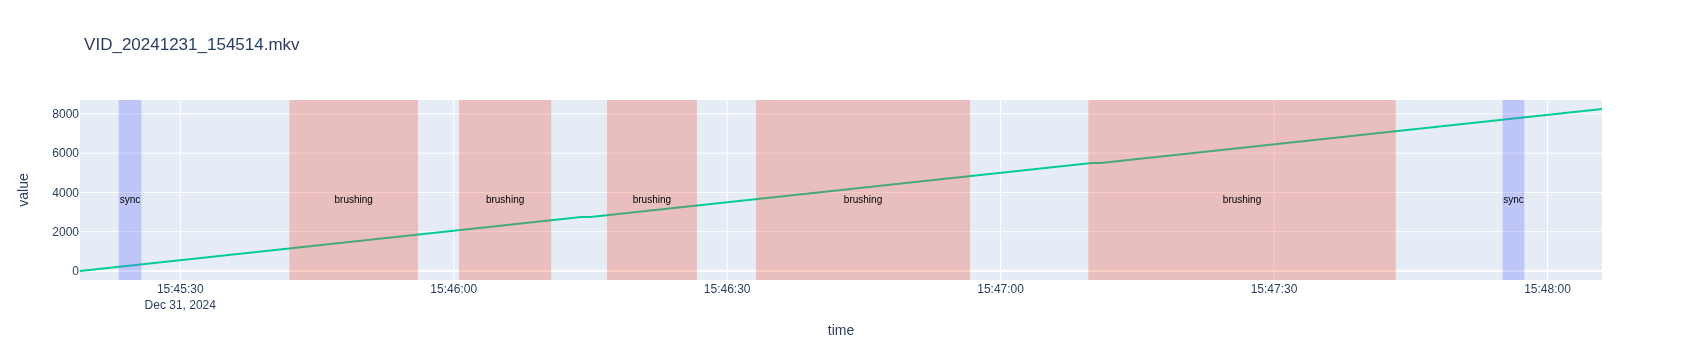

VID_20241231_155624.mkv


/usr/lib/python3.13/site-packages/plotly/io/_json.py:554: UserWarning:

Discarding nonzero nanoseconds in conversion.



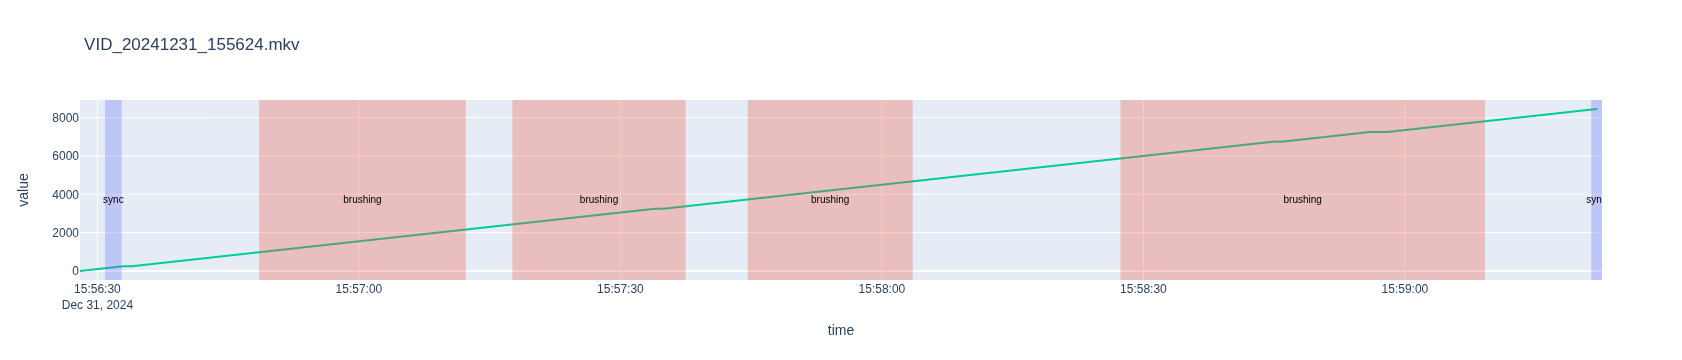

VID_20241231_163515.mkv


/usr/lib/python3.13/site-packages/plotly/io/_json.py:554: UserWarning:

Discarding nonzero nanoseconds in conversion.



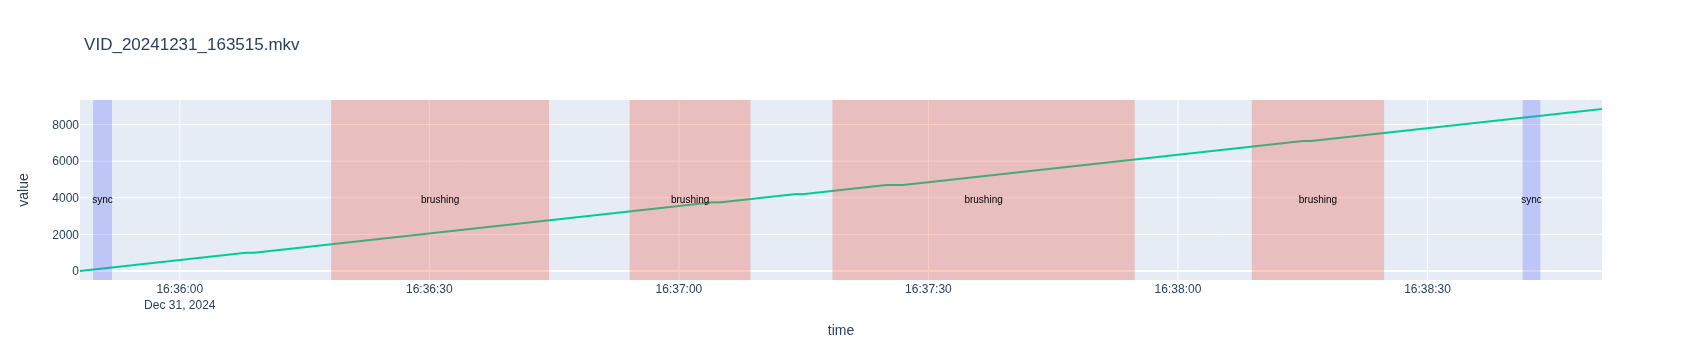

VID_20241231_164646.mkv


/usr/lib/python3.13/site-packages/plotly/io/_json.py:554: UserWarning:

Discarding nonzero nanoseconds in conversion.



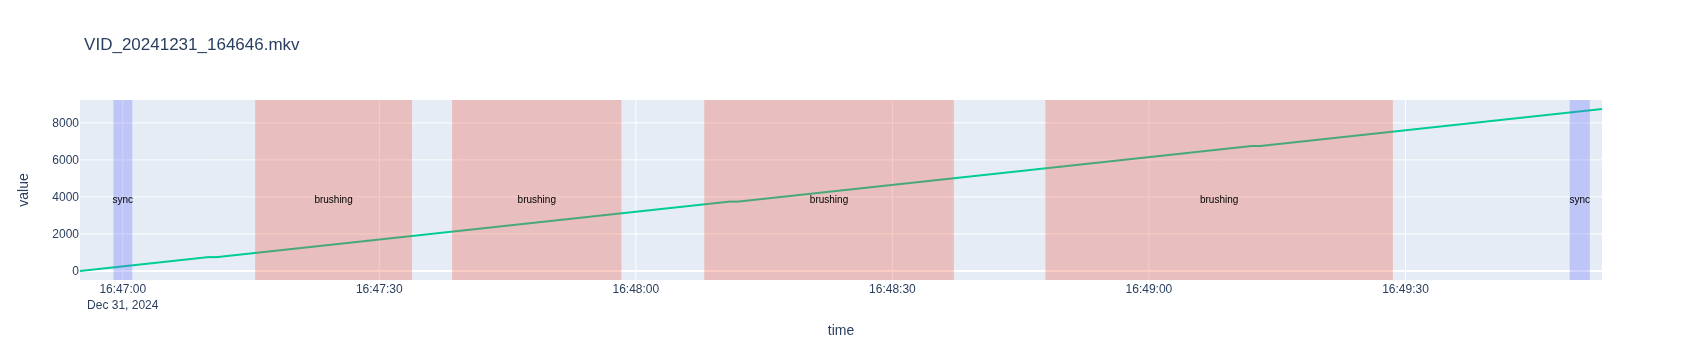

In [17]:

def plot_session(sensors, labels, title=None, height=300, aspect=3.0):

    time_column = 'time'
    columns = ['x', 'y', 'z']
    width = height * aspect
    annotation_column = 'class'
    
    # TODO: plot other values than raw XYZ.
    # Like motion, from removing gravity. Maybe overall RMS, delta rms, band-passed 2-5hz instead of  
    sel = sensors.reset_index()
    fig = plotly.express.line(sel,
                              x=time_column,
                              y=columns,
                              width=width,
                              height=height,
                              title=title,
                             )
    fig.update_traces(connectgaps=False)
    fig.update_layout(showlegend=False)

    colors = plotly.express.colors.qualitative.Plotly

    types = labels[annotation_column].unique()
    annotation_colors = { v: c for v, c in zip(types, colors) }
    
    # FIXME: put this on the bottom
    for idx, l in labels.iterrows():
        #print(dict(l))
        color = annotation_colors[l[annotation_column]]
        fig.add_vrect(x0=l['start_time'],
                x1=l['end_time'],
                line_width=0,
                fillcolor=color,
                opacity=0.3,
                label=dict(
                    text=l[annotation_column],
                    textposition="start",
                    font=dict(size=10, color="black"),
                    yanchor="top",
                ),
         )
    
    return fig

for session, session_data in ss.groupby('session'):
    print(session)
    ll = mm.set_index('filename').loc[session]
    fig = plot_session(session_data, ll, title=session)
    fig.show()

In [ ]:
ss.to_parquet('combined.parquet')